In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import scipy.stats as st
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import glob


In [2]:
run ../util/setupConsole_su

In [4]:
x=xr.open_dataset('../../../obbudelm-F21/decile_bins/era5_Maize_tasmax_growing_season_deciles_1981.nc')

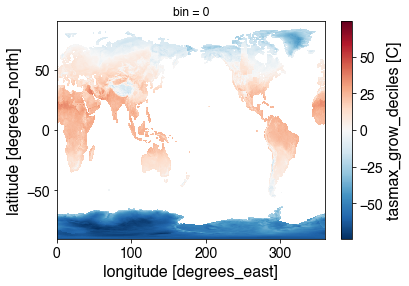

In [9]:
x.tasmax_grow_deciles[:,:,0].plot()

In [20]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

# dirAgData = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'
# dirEra5 = '/dartfs-hpc/rc/lab/C/CMIG/ERA5'

years = [1979, 2019]

year = 1980

In [21]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dirAgData)
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [23]:
# calc era5 quantiles
ds_tasmax = xr.open_mfdataset('%s/daily/tasmax_%d.nc'%(dirEra5, year))
ds_tasmax.load()
ds_tasmax['mx2t'] -= 273.15

ds_tasmax_last_year = xr.open_mfdataset('%s/daily/tasmax_%d.nc'%(dirEra5, year-1))
ds_tasmax_last_year.load()
ds_tasmax_last_year['mx2t'] -= 273.15

# ds_tp = xr.open_mfdataset('%s/monthly/tp_*.nc'%dirEra5)
# ds_tp.load()
# ds_quantile = ds.chunk({'latitude':500, 'longitude':500, 'time': -1}).quantile(q=[.01, .05, .1, .9, .95, .99], dim='time')
# ds_quantile.tw.to_netcdf('era5_tw_mean_quantiles.nc')

In [24]:
lat = ds_tasmax.latitude.values
lon = ds_tasmax.longitude.values

# regrid sacks data
regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_start = xe.Regridder(xr.DataArray(data=sacksStart, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear')
regridder_end = xe.Regridder(xr.DataArray(data=sacksEnd, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear')

sacksStart_regrid = regridder_start(sacksStart, reuse_weights=True)
sacksEnd_regrid = regridder_end(sacksEnd, reuse_weights=True)

Overwrite existing file: bilinear_360x720_721x1440.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_360x720_721x1440.nc 
 You can set reuse_weights=True to save computing time.


TypeError: __call__() got an unexpected keyword argument 'reuse_weights'

In [19]:
def is_growing_season(day, sacks_start, sacks_end):
    if sacks_start < sacks_end:
        return (day >= sacks_start) & (day <= sacks_end)
    else:
        return (day >= sacks_start) | (month <= sacks_end)

In [16]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)

In [ ]:
nnLen = np.where((~np.isnan(crop_ha_regrid.reshape([crop_ha_regrid.size,1]))))[0].size

In [ ]:
%%time
n = 0

bins = np.arange(0, 1.01, .1)

growing_season_tasmax_quantiles = np.full([len(lat), len(lon), bins.size], np.nan)
growing_season_tp_quantiles = np.full([len(lat), len(lon), bins.size], np.nan)

for xlat in range(len(lat)):

    for ylon in range(len(lon)):

        if ~np.isnan(sacksStart_regrid[xlat, ylon]) and ~np.isnan(sacksEnd_regrid[xlat, ylon]) and crop_ha_regrid[xlat, ylon] > 0:

            if n % 1000 == 0:
                print('%.1f %% complete'%(n/(nnLen)*100))
            
            # select growing seasons for all years
            ds_tasmax_growing = ds_tasmax.mx2t[:,xlat,ylon].sel(time=is_growing_season(ds_tasmax['time.month'], sacks_start_month, sacks_end_month))
            ds_tp_growing = ds_tp.tp[:,xlat,ylon].sel(time=is_growing_season(ds_tasmax['time.month'], sacks_start_month, sacks_end_month))

            # resample to group growing seasons (1 year frequency, offset starting at 1 month before start of growing season)
            ds_tasmax_growing_1y = ds_tasmax_growing.resample(time='1Y', loffset='%dM'%(sacks_start_month-1)).mean()
            ds_tp_growing_1y = ds_tp_growing.resample(time='1Y', loffset='%dM'%(sacks_start_month-1)).mean()

            # calculate quantiles across all growing seasons
            tasmax_q = ds_tasmax_growing_1y.chunk({'time': -1}).quantile(q=[.75, .9, .95, .99], dim='time', skipna=True)
            tp_q = ds_tp_growing_1y.chunk({'time': -1}).quantile(q=[.75, .9, .95, .99], dim='time', skipna=True)

            growing_season_tasmax_quantiles[xlat, ylon, :] = tasmax_q.values
            growing_season_tp_quantiles[xlat, ylon, :] = tp_q.values

            n += 1
                
#                 sys.exit()

In [ ]:
%%time
n = 0

bins = np.arange(0, 1.01, .1)

growing_season_tasmax_quantiles = np.full([len(lat), len(lon), bins.size], np.nan)
growing_season_tp_quantiles = np.full([len(lat), len(lon), bins.size], np.nan)

for xlat in range(len(lat)):

    for ylon in range(len(lon)):

        if ~np.isnan(sacksStart_regrid[xlat, ylon]) and ~np.isnan(sacksEnd_regrid[xlat, ylon]) and crop_ha_regrid[xlat, ylon] > 0:

            if n % 1000 == 0:
                print('%.1f %% complete'%(n/(nnLen)*100))

            sacks_start_month = datetime.datetime.strptime('2020%d'%int(sacksStart_regrid[xlat,ylon]), '%Y%j').date().month
            sacks_end_month = datetime.datetime.strptime('2020%d'%int(sacksEnd_regrid[xlat,ylon]), '%Y%j').date().month
            
            # select growing seasons for all years
            ds_tasmax_growing = ds_tasmax.mx2t[:,xlat,ylon].sel(time=is_growing_season(ds_tasmax['time.month'], sacks_start_month, sacks_end_month))
            ds_tp_growing = ds_tp.tp[:,xlat,ylon].sel(time=is_growing_season(ds_tasmax['time.month'], sacks_start_month, sacks_end_month))

            # resample to group growing seasons (1 year frequency, offset starting at 1 month before start of growing season)
            ds_tasmax_growing_1y = ds_tasmax_growing.resample(time='1Y', loffset='%dM'%(sacks_start_month-1)).mean()
            ds_tp_growing_1y = ds_tp_growing.resample(time='1Y', loffset='%dM'%(sacks_start_month-1)).mean()

            # calculate quantiles across all growing seasons
            tasmax_q = ds_tasmax_growing_1y.chunk({'time': -1}).quantile(q=[.75, .9, .95, .99], dim='time', skipna=True)
            tp_q = ds_tp_growing_1y.chunk({'time': -1}).quantile(q=[.75, .9, .95, .99], dim='time', skipna=True)

            growing_season_tasmax_quantiles[xlat, ylon, :] = tasmax_q.values
            growing_season_tp_quantiles[xlat, ylon, :] = tp_q.values

            n += 1
                
#                 sys.exit()

0.0 % complete
1.1 % complete
2.2 % complete
3.3 % complete
4.4 % complete
5.5 % complete
6.6 % complete
7.7 % complete
8.8 % complete
9.9 % complete
11.0 % complete
12.1 % complete
13.2 % complete
14.3 % complete
15.4 % complete
16.5 % complete
17.6 % complete
18.7 % complete
19.8 % complete
20.9 % complete
22.0 % complete
23.1 % complete
24.2 % complete
25.4 % complete
26.5 % complete
27.6 % complete
28.7 % complete
29.8 % complete
30.9 % complete
32.0 % complete
33.1 % complete
34.2 % complete
35.3 % complete
36.4 % complete
37.5 % complete
38.6 % complete
39.7 % complete
40.8 % complete
41.9 % complete
43.0 % complete
44.1 % complete
45.2 % complete
46.3 % complete
47.4 % complete
48.5 % complete
49.6 % complete
50.7 % complete
51.8 % complete
